## TODO
### Need to run for longer epochs and see the results.

In [1]:
import os
import random
import numpy as np
import torch


def set_seed(seed):

    random.seed(seed)     # python random generator
    np.random.seed(seed)  # numpy random generator

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    
set_seed(42)

In [2]:
import torch
import torchvision

def get_net():
    resnet = torchvision.models.resnet34(pretrained=True)
    
    # Substitute the FC output layer
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 5)
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

In [3]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        
        classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())

        # Initialize the label encoder
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(classes)

        # Initialize the one hot encoder
        onehot_encoder = OneHotEncoder(sparse_output=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

        # Create a dictionary to map the classes to the one hot encoding
        class_dict = {}
        for i in range(len(classes)):
            class_dict[classes[i]] = onehot_encoded[i]
            
        self.class_dict = class_dict
        print(self.class_dict)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_frame.iloc[idx]['path'])
        image = Image.open(img_name).convert('RGB')
        label = self.data_frame.iloc[idx]['class']
        
        if self.transform:
            image = self.transform(image)

        return image, self.class_dict[label]

# Define the transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize([0.5], [0.5]),  # Normalize the image (mean and std for grayscale)
    transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x))  # Add small random noise to the image
])

# Initialize the dataset
TrainDataset = CustomImageDataset(csv_file='/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv', transform=data_transforms)
TestDataset = CustomImageDataset(csv_file='/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/test_data.csv', transform=data_transforms)

print(TrainDataset.__getitem__(0))
print(TestDataset.__getitem__(1))

{'Age_related_Macular_Degeneration': array([1., 0., 0., 0., 0.]), 'Central_serous': array([0., 1., 0., 0., 0.]), 'Diabetic': array([0., 0., 1., 0., 0.]), 'Macular_Hole': array([0., 0., 0., 1., 0.]), 'Normal': array([0., 0., 0., 0., 1.])}
{'Age_related_Macular_Degeneration': array([1., 0., 0., 0., 0.]), 'Central_serous': array([0., 1., 0., 0., 0.]), 'Diabetic': array([0., 0., 1., 0., 0.]), 'Macular_Hole': array([0., 0., 0., 1., 0.]), 'Normal': array([0., 0., 0., 0., 1.])}
(tensor([[[-0.9910, -1.0211, -0.9932,  ..., -0.9831, -0.9998, -1.0083],
         [-0.9985, -1.0106, -1.0057,  ..., -1.0075, -1.0058, -0.9865],
         [-1.0100, -0.9997, -1.0043,  ..., -1.0167, -1.0002, -1.0121],
         ...,
         [-1.0016, -1.0038, -1.0008,  ..., -0.9854, -0.9916, -0.9981],
         [-1.0034, -0.9933, -0.9876,  ..., -1.0127, -1.0066, -1.0052],
         [-1.0052, -0.9919, -1.0031,  ..., -1.0041, -1.0066, -0.9976]],

        [[-1.0035, -0.9746, -0.9889,  ..., -1.0034, -1.0051, -1.0112],
         [

In [4]:
train_dataloader = DataLoader(TrainDataset, batch_size=4)
valid_dataloader = DataLoader(TestDataset, batch_size=4)

In [5]:
# #! create the one hot encoding for the classes from the train datalaoader
# import numpy as np
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

# # Get the classes from the dataloader
# classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())

# # Initialize the label encoder
# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(classes)

# # Initialize the one hot encoder
# onehot_encoder = OneHotEncoder(sparse_output=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# # Create a dictionary to map the classes to the one hot encoding
# class_dict = {}
# for i in range(len(classes)):
#     class_dict[classes[i]] = onehot_encoded[i]
    
# class_dict


In [6]:
from tqdm import tqdm
import time

def train(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='mps', checkpoint_epochs=10):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        
        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        for X, y in tqdm(train_dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(torch.float32).to(device)
            preds = net(X)
            # print(preds.shape)
            loss = criterion(preds, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == torch.argmax(y, dim=1)).sum()
        
        if valid_dataloader is not None:
            net.eval()  # put network in train mode for Dropout and Batch Normalization
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y in valid_dataloader:
                    X = X.to(torch.float32).to(device)
                    y = y.to(torch.float32).to(device)
                    preds = net(X)
                    loss = criterion(preds, y)

                    valid_loss += loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == torch.argmax(y, dim=1)).sum()
        
        if scheduler is not None: 
            scheduler.step()
            
        print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
        print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')
        
        if valid_dataloader is not None:
            print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
            print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')
        
        if epoch%checkpoint_epochs==0:
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './weights/23aug_checkpoint.pth.tar')
        
        print()
    
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net

In [8]:
DO_train=False

In [9]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
lr, weight_decay, epochs = 1e-5, 5e-4, 100

net = get_net().to(device)

# Standard CrossEntropy Loss for multi-class classification problems
criterion = torch.nn.CrossEntropyLoss()

# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
params_1x = [param for name, param in net.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.Adam([{'params':params_1x}, {'params': net.fc.parameters(), 'lr': lr*10}], lr=lr, weight_decay=weight_decay)
if DO_train:
    net = train(net, train_dataloader, valid_dataloader, criterion, optimizer, None, epochs, device)
else:
    net.load_state_dict(torch.load('./weights/checkpoint.pth.tar', map_location=device)["state_dict"])
    net.to(device)

/Users/asmitganguly/miniconda3/envs/mlx/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/asmitganguly/miniconda3/envs/mlx/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/1x/ys4528cx32123ww1dck2swg40000gn/T/ipykernel_8997/1527371525.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during 

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net)

21287237

## TEST

In [11]:
import time
from sklearn.metrics import precision_score, recall_score, f1_score


def test(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='mps', checkpoint_epochs=10):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    
    # for epoch in range(1,epochs+1):
    #     print(f"Epoch {epoch}/{epochs}")
        
    #     net.train()  # put network in train mode for Dropout and Batch Normalization
    #     train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
    #     train_accuracy = torch.tensor(0., device=device)
    #     for X, y in train_dataloader:
    #         X = X.to(torch.float32).to(device)
    #         y = y.to(torch.float32).to(device)
    #         preds = net(X)
    #         # print(preds.shape)
    #         loss = criterion(preds, y)
            
    #         optimizer.zero_grad()
    #         loss.backward()
    #         optimizer.step()
            
    #         with torch.no_grad():
    #             train_loss += loss * train_dataloader.batch_size
    #             train_accuracy += (torch.argmax(preds, dim=1) == torch.argmax(y, dim=1)).sum()
    results = {
        'precision': [],
        'recall': [],
        'f1': [],
        'predictions': [],
        'targets': []
    }
    if valid_dataloader is not None:
        net.eval()  # put network in train mode for Dropout and Batch Normalization
        valid_loss = torch.tensor(0., device=device)
        valid_accuracy = torch.tensor(0., device=device)
        with torch.no_grad():
            for X, y in valid_dataloader:
                X = X.to(torch.float32).to(device)
                y = y.to(torch.float32).to(device)
                preds = net(X)
                # print(preds.shape, y.shape)
                loss = criterion(preds, y)

                
                
                valid_loss += loss * valid_dataloader.batch_size
                valid_accuracy += (torch.argmax(preds, dim=1) == torch.argmax(y, dim=1)).sum()
                
                all_predictions = torch.argmax(preds, dim=1).cpu().numpy()
                all_targets = torch.argmax(y, dim=1).cpu().numpy()
                precision = precision_score(all_targets, all_predictions, average=None)
                recall = recall_score(all_targets, all_predictions, average=None)
                f1 = f1_score(all_targets, all_predictions, average=None)
                
                results['precision'].append(precision)
                results['recall'].append(recall)
                results['f1'].append(f1)
                results['predictions'].append(all_predictions)
                results['targets'].append(all_targets)
    
    if scheduler is not None: 
        scheduler.step()
        
    # print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
    # print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')
    
    if valid_dataloader is not None:
        print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
        print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')
    
    # if epoch%checkpoint_epochs==0:
    #     torch.save({
    #         'epoch': epoch,
    #         'state_dict': net.state_dict(),
    #         'optimizer': optimizer.state_dict(),
    #     }, './weights/checkpoint.pth.tar')
    
    # print()
    
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net, results

In [12]:
len(valid_dataloader)

29

Training for 100 epochs on mps


/Users/asmitganguly/miniconda3/envs/mlx/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asmitganguly/miniconda3/envs/mlx/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asmitganguly/miniconda3/envs/mlx/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Valid loss: 0.14
Valid accuracy: 94.78
Total training time: 1.1 seconds
{'precision': [array([1., 1., 1., 1.]), array([1., 1., 1.]), array([1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1.]), array([0. , 0.5, 1. ]), array([1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1., 1.]), array([1., 1., 1.]), array([1., 1.]), array([1., 1., 1.]), array([1., 1.]), array([1., 1.]), array([1.        , 0.66666667, 0.        ]), array([1., 1., 1.]), array([0., 0., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 0., 0.]), array([0., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1.])], 'recall': [array([1., 1., 1., 1.]), array([1., 1., 1.]), array([1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1.]), array([0., 1., 1.]), array([1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1., 1.]), array([1., 1., 1.]), array([1., 1.]), array([1., 1

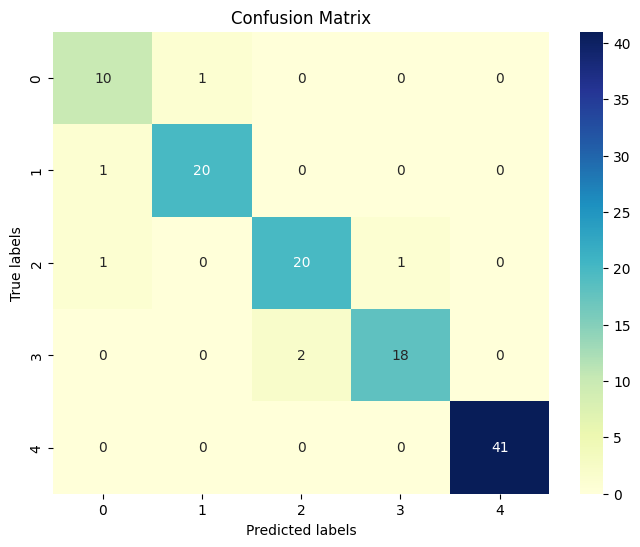

[0.90909091 0.95238095 0.90909091 0.9        1.        ]


In [29]:
net, results = test(net, train_dataloader, valid_dataloader, criterion, optimizer, None, epochs, device)
print(results)
result_final = {
    'precision': [],
    'recall': [],
    'f1': [],
    'predictions': [],
    'targets': []
}

for k in results.keys():
    for ll in results[k]:
        for ele in ll:
            result_final[k].append(ele)
            
# print(result_final)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(result_final["targets"], result_final["predictions"])

# display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

def class_wise_accuracy(confusion_matrix):
    return np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)


accuracy_per_class = class_wise_accuracy(cm)
print(accuracy_per_class)

In [24]:
from tqdm import tqdm
test_loss = 0.0
classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
net.eval()

trainLoad = DataLoader(TrainDataset, batch_size=4)
testLoad = DataLoader(TestDataset, batch_size=4)

for data, target in tqdm(testLoad):
    data, target = data.to(torch.float32).to(device), target.argmax(dim=1).to(torch.int64).to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = net(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # print(len(target))
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    

test_loss = test_loss / (len(valid_dataloader)*4)
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 29/29 [00:01<00:00, 21.26it/s]

Test Loss: 0.0012
Test Accuracy of Age_related_Macular_Degeneration: 81% ( 9/11)
Test Accuracy of Central_serous: 100% (21/21)
Test Accuracy of Diabetic: 95% (21/22)
Test Accuracy of Macular_Hole: 100% (20/20)
Test Accuracy of Normal: 100% (41/41)
Test Accuracy of 97% (112/115)


### Explainability

In [35]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

# model = resnet50(pretrained=True)
target_layers = [net.layer4[-1]]
# Define the transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    # transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    # transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize([0.5], [0.5]),  # Normalize the image (mean and std for grayscale)
    # transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x))  # Add small random noise to the image
])
TrainDataset = CustomImageDataset(csv_file='/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv', transform=data_transforms)

input_tensor, label = TrainDataset.__getitem__(0)
input_tensor =  torch.tensor(input_tensor).to(torch.float32)
label =  torch.tensor(label).to(torch.float32)
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=net, target_layers=target_layers)
visuals = []
cams = []
for cam in [GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad]:
    cam = cam(model=net, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(dim=0), targets=None)
    grayscale_cam = grayscale_cam[0, :]
    array = input_tensor.numpy()
    array = np.transpose(array, (1, 2, 0))
    min_val, max_val = np.min(array), np.max(array)
    visualization = show_cam_on_image((array - min_val) / (max_val - min_val), grayscale_cam, use_rgb=False)
    visuals.append(visualization)
    cams.append(grayscale_cam)
    
    
# cam = HiResCAM(model=net, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# targets = None
# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(dim=0), targets=targets)

# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# array = input_tensor.numpy()
# array = np.transpose(array, (1, 2, 0))
# min_val, max_val = np.min(array), np.max(array)
# visualization = show_cam_on_image((array - min_val) / (max_val - min_val), grayscale_cam, use_rgb=False)

# # You can also get the model outputs without having to re-inference
# model_outputs = cam.outputs

{'Age_related_Macular_Degeneration': array([1., 0., 0., 0., 0.]), 'Central_serous': array([0., 1., 0., 0., 0.]), 'Diabetic': array([0., 0., 1., 0., 0.]), 'Macular_Hole': array([0., 0., 0., 1., 0.]), 'Normal': array([0., 0., 0., 0., 1.])}


/var/folders/1x/ys4528cx32123ww1dck2swg40000gn/T/ipykernel_8997/2682837723.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor =  torch.tensor(input_tensor).to(torch.float32)
100%|██████████| 16/16 [00:01<00:00, 12.12it/s]


In [36]:
label

tensor([1., 0., 0., 0., 0.])

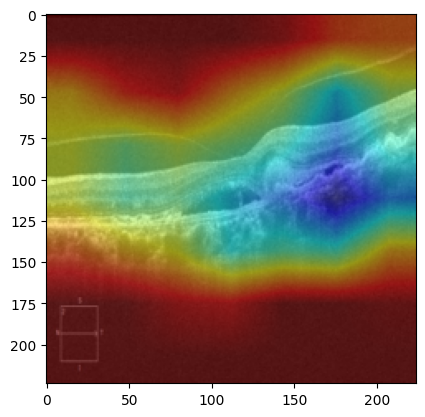

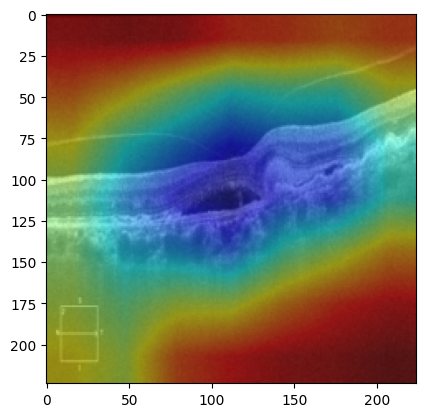

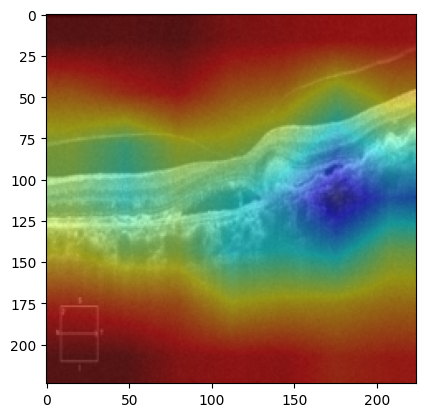

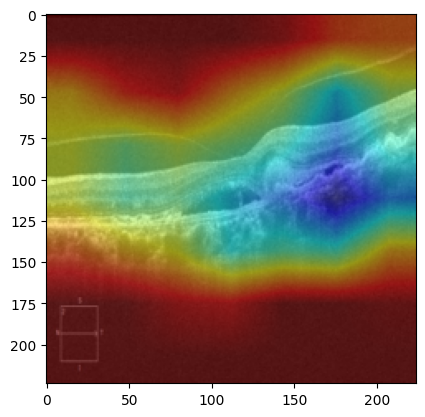

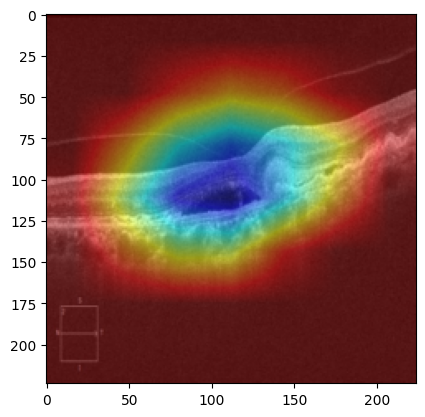

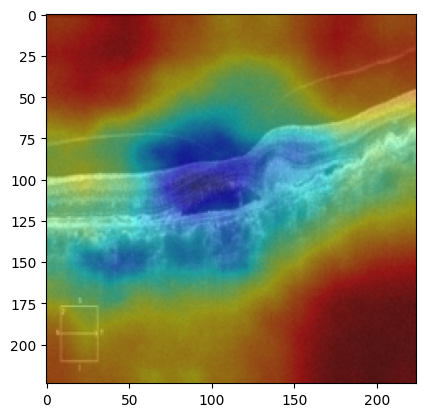

In [37]:
# from matplotlib import pyplot as plt
# plt.imshow(visualization)
# plt.show()

for vis in visuals:
    
    plt.imshow(vis)
    plt.show()

In [38]:
np.save("resnet-map.npy",cams[-2])
